In [1]:
from math import *
from numpy import sign

import numpy as np
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib
import matplotlib.cbook 
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as rand

from matplotlib import rc


rc('text', usetex=True)
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=20)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=20)

matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{graphics,graphicx,rotating}'
]

%matplotlib inline  



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
num=1000
def get(num):
    ! cd ntuple_Tchannel
    mylist=! ls ntuple_Tchannel/tchannel_up_$num*.evt
    return mylist

get(1000)

['ntuple_Tchannel/tchannel_up_1000_rinv0.01.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.1.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.2.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.3.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.4.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.5.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.6.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.7.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.8.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.98.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.99.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv0.9.evt',
 'ntuple_Tchannel/tchannel_up_1000_rinv1.0.evt']

### Read input

In [89]:
def readfile(name, folder='ntuple_Tchannel/', lumi=1, cxn=None):
    data = pd.read_csv(folder+name+'.evt', header=0, delimiter=',', skipinitialspace=True)
    data.meta = pd.read_csv(folder+name+'.meta', header=0, delimiter=',', skipinitialspace=True)
    if 'weight' in data.columns:
        data['weight'] *= (data.meta['cxn']*lumi/data.meta['sum_weight'])[0]
    else:
        data['weight'] = (data.meta['cxn']*lumi / data.meta['nevt'])[0]  
    if cxn is not None:
        data['weight'] = (cxn*lumi / data.meta['nevt'])[0]  
    return data

bkg = ['bkg_ttbar_dilep_0',  'bkg_ttbar_semilep_0',  'bkg_Wj_0',  'bkg_Zj_0']
bkg = [ readfile(f,folder='ntuple_Zprime/') for f in bkg ]

def nbkg(cut, lumi=37*1000):
    mybkg = [ f.query(cut) for f in bkg ]
    myevt = np.asarray([ lumi*np.sum(f['weight']) for f in mybkg ])
    return myevt

b = 10**np.linspace(log10(500),log10(10000),101)

cxn3000= .03951
cxn5000= .0103

def get_sig(mass):
    sigup = ['tchannel_up_mass_rinv0.01',
        'tchannel_up_mass_rinv0.1',
        'tchannel_up_mass_rinv0.2',
        'tchannel_up_mass_rinv0.3',
        'tchannel_up_mass_rinv0.4',
        'tchannel_up_mass_rinv0.5',
        'tchannel_up_mass_rinv0.6',
        'tchannel_up_mass_rinv0.7',
        'tchannel_up_mass_rinv0.8',
        'tchannel_up_mass_rinv0.9',
        'tchannel_up_mass_rinv0.98',
        'tchannel_up_mass_rinv0.99',
        'tchannel_up_mass_rinv1.0'
        ]
    
    sigdown = ['tchannel_down_mass_rinv0.01',
        'tchannel_down_mass_rinv0.1',
        'tchannel_down_mass_rinv0.2',
        'tchannel_down_mass_rinv0.3',
        'tchannel_down_mass_rinv0.4',
        'tchannel_down_mass_rinv0.5',
        'tchannel_down_mass_rinv0.6',
        'tchannel_down_mass_rinv0.7',
        'tchannel_down_mass_rinv0.8',
        'tchannel_down_mass_rinv0.9',
        'tchannel_down_mass_rinv0.98',
        'tchannel_down_mass_rinv0.99',
        'tchannel_down_mass_rinv1.0'
        ]
    
    sigup = [ s.replace('mass',str(mass)) for s in sigup ]
    sigdown = [ s.replace('mass',str(mass)) for s in sigdown ]
    
    sigup = [ readfile(f) for f in sigup ]
    sigup_cxn = [ f.meta['cxn'] for f in sigup ]
    
    sigdown = [ readfile(f) for f in sigdown ]
    sigdown_cxn = [ f.meta['cxn'] for f in sigdown ]
    
    #sig_Mt = [ np.histogram(f['Mt'],bins=b,weights=f['weight'])[0] for f in sigup ]
    return [ sigup, sigdown ]

sig1000=get_sig(1000)


In [90]:
def nsig(sig, cut, lumi=37*1000, mix=[4./(4./3 *.59)**2 , 4./(2./3 *.59)**2]):
    [ sig1, sig2 ] = sig
    mysig1 = [ f.query(cut) for f in sig1 ]
    mysig2 = [ f.query(cut) for f in sig2 ]
    
    myevt1 = np.asarray([ mix[0]*lumi*np.sum(f['weight']) for f in mysig1 ])
    myevt2 = np.asarray([ mix[1]*lumi*np.sum(f['weight']) for f in mysig2 ])
    
    return myevt1+myevt2

In [91]:
nsig(sig1000, 'MEt > 800 & dphi <.4')

array([  0.24009764,   3.45535851,   8.90761263,  17.11336115,
        26.89038303,  39.33994646,  51.88925394,  61.55136053,
        65.14581848,  52.10900182,  19.06989596,  13.1666231 ,   7.13726464])

In [97]:
cutlist1=['MEt > 1000 & dphi <.4', 'MEt > 1200 & dphi <.4', 
          'MEt > 1000 & dphi <.4 & pt3 > 80', 'MEt > 1200 & dphi <.4 & pt3 > 80',
          'MEt > 1000 & dphi <.4 & pt3 > 100', 'MEt > 1200 & dphi <.4 & pt3 > 100',
         ]

cutlist2=['MEt > 800 & dphi >.4', 'MEt > 1000 & dphi >.4', 'MEt > 1200 & dphi >.4',
          'MEt > 800 & dphi >.4 & pt3 > 80', 'MEt > 1000 & dphi >.4 & pt3 > 80', 'MEt > 1200 & dphi >.4 & pt3 > 80',
          'MEt > 800 & dphi >.4 & pt3 > 100', 'MEt > 1000 & dphi >.4 & pt3 > 100', 'MEt > 1200 & dphi >.4 & pt3 > 100'        
         ]

commoncut=' & pt3 > 50'

cutnbkg1=[ np.sum(nbkg(c+commoncut)) for c in cutlist1 ]
cutnbkg2=[ np.sum(nbkg(c+commoncut)) for c in cutlist2 ]

cutnsig1=[ nsig(sig1000, c+commoncut) for c in cutlist1 ]
cutnsig2=[ nsig(sig1000, c+commoncut) for c in cutlist2 ]


from scipy.optimize import bisect
def limit(nbkg):
    
    def func_root(x):
        logpart = x-nbkg*np.log(1+x/nbkg)
        my_val = logpart - 2.0
        return my_val
    
    soln = bisect(func_root, 0,10*nbkg)
    return soln

def limit_list(nbkg):
    return np.asarray([ limit(n) for n in nbkg ])

cutlim1 = [ limit(n) for n in cutnbkg1 ]
cutlim2 = [ limit(n) for n in cutnbkg2 ]

exc_sig_factor1 = np.asarray([ cutlim1[i]/l for i,l in enumerate(cutnsig1)])
exc_sig_factor2 = np.asarray([ cutlim2[i]/l for i,l in enumerate(cutnsig2)])

exc_sig_factor1 = np.amin(exc_sig_factor1, axis=0)
exc_sig_factor2 = np.amin(exc_sig_factor2, axis=0)

print(exc_sig_factor1)
print(exc_sig_factor2)

cutoff1 = 1000./exc_sig_factor1**(1./4)
cutoff2 = 1000./exc_sig_factor2**(1./4)
print(cutoff1)

[ 156.98661239   10.86901049    4.14806001    2.50078512    1.6021459
    1.25317874    1.04535507    1.03705401    1.21107788    2.150262
   11.70302492   21.90823648   79.89680761]
[ 2122.06111835   278.05560057   125.45094176    55.14733096    20.2739759
    13.61627678     9.00731137     5.293088       4.85954329     5.44623712
     7.55917156     8.71266451    10.43068528]
[ 282.51033851  550.74745384  700.71068865  795.20830269  888.84182948
  945.14130937  988.97210495  990.94524088  953.25036818  825.80432896
  540.66152805  462.21937394  334.47806593]


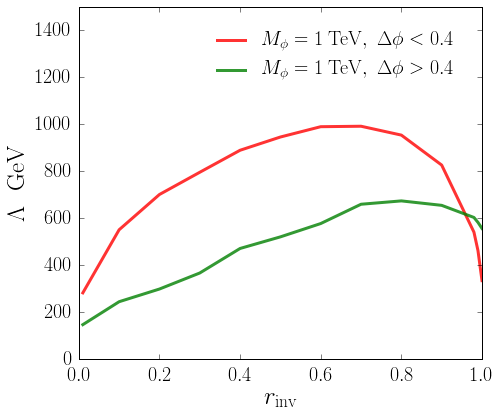

In [100]:
plt.figure()

fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

rinv=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.98,.99,1]

plt.plot(rinv,cutoff1,label=r'$M_\phi = 1\;{\rm TeV},\; \Delta \phi < 0.4$',lw=3,alpha=.8,c='red')
plt.plot(rinv,cutoff2,label=r'$M_\phi = 1\;{\rm TeV},\; \Delta \phi > 0.4$',lw=3,alpha=.8,c='green')

plt.ylim([0,1500])
plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ \Lambda\,\,{\rm\; GeV}$', fontsize=25)

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)

plt.savefig("cutoff_tchannel_associated.png")

In [6]:
sig3000[1][1]

,evt,MEt,mjj,Mt,pt1,eta1,y1,pt2,eta2,y2,...,eta3,y3,pt4,eta4,y4,dphi,nj,n_meson,n_glu,weight
0,0,52.3847,0,4646.70,2260.85,0.067033,0.066485,2108.270,-0.536935,-0.535818,...,0.053518,0.053369,470.0810,-0.819088,-0.817318,0.202048,5,15,0,1.614673e-13
1,1,40.1156,0,5034.20,2079.02,0.579396,0.579083,2078.880,-0.663434,-0.661346,...,1.528700,1.522920,-1.0000,999.000000,0.000000,0.950443,3,13,0,1.614673e-13
2,2,130.2110,0,4948.77,1934.36,-0.469354,-0.468199,1788.030,1.004520,0.984616,...,0.325860,0.320912,44.5904,0.563556,0.556184,0.192287,4,29,0,1.614673e-13
3,3,223.3150,0,4851.23,2570.86,0.331948,0.330540,1974.440,0.028324,0.028102,...,0.189761,0.188542,83.6755,-0.154386,-0.149074,0.082910,7,43,0,1.614673e-13
4,4,163.3520,0,5157.39,3149.47,0.226322,0.225934,1545.880,-0.497232,-0.491312,...,-0.013378,-0.013243,227.9020,1.152610,1.143790,0.257481,6,45,0,1.614673e-13
5,5,156.8770,0,4641.52,2149.16,-0.672455,-0.671867,1141.160,1.048970,1.046480,...,-0.480655,-0.477388,306.5810,-0.473538,-0.464371,0.165986,7,30,0,1.614673e-13
6,6,643.7500,0,5918.88,2977.46,0.097803,0.097518,2278.270,0.016810,0.016770,...,-0.602593,-0.583284,31.5367,0.550726,0.538890,0.067716,4,24,0,1.614673e-13
7,7,85.2300,0,4926.85,2325.38,0.313508,0.311946,2272.770,-0.315512,-0.315128,...,0.743677,0.732351,51.4546,0.753532,0.739954,0.245758,5,27,0,1.614673e-13
8,8,97.9206,0,4485.58,2420.51,0.805334,0.803642,1758.780,0.228112,0.226238,...,0.609015,0.605751,287.5430,0.322906,0.317285,0.418585,6,33,0,1.614673e-13
9,9,481.4290,0,5232.94,2382.17,-0.300509,-0.299293,2238.630,0.085893,0.084691,...,0.330780,0.327062,160.5510,0.135794,0.131095,0.013823,7,64,0,1.614673e-13


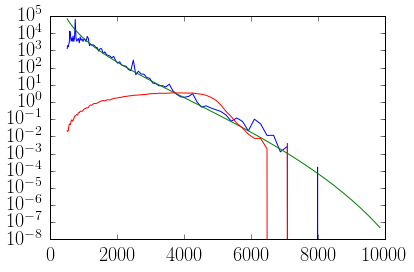

In [18]:
bw = np.array(b[1:]-b[:-1])
bc = np.sqrt(b[1:]*b[:-1])

bkg_errbins = np.asarray([ np.histogram(f['Mt'],bins=b, weights = f['weight']**2)[0] for f in bkg ])
total_bkgerr=np.sqrt(bkg_errbins.sum(axis=0))

bkg_bins = np.asarray([ np.histogram(f['Mt'],bins=b, weights = f['weight'])[0] for f in bkg ])
total_bkg=bkg_bins.sum(axis=0)

val=[3.27816*1e-3, 17.1227, -7.85266, 0.00920465, -0.503524]

def func(b,param=val):
    x=b/13000.
    p1=(val[1]+val[2]*np.log(x))
    p2=(val[3]+val[4]*np.log(x))
    return val[0]*(1-x)**p1/(x)**p2

lumi=37*1000
plt.plot(bc,total_bkg*lumi)
plt.plot(bc,func(bc)*bw*lumi)
plt.plot(bc,sig5000[5]*lumi)
plt.yscale('log')
plt.show()

[  16.65288478    2.24727784    1.50436714    1.37437737    1.51087856
    1.82360243    2.5037579     3.97729772    7.58550299   19.16986201
   80.65051381  115.87687983  171.6086075 ]
[  13.30830491    1.74678879    1.12634779    1.03160959    1.10951256
    1.37180559    1.9500908     3.14228233    6.28311033   19.1438003
  167.72897938  323.52898948  597.95894646]


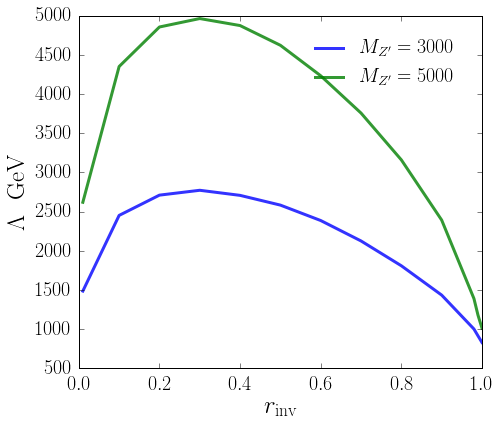

In [19]:
from scipy.optimize import bisect
def limit(sig,lumi_scale=37*1000):
    
    sig_c = sig*lumi_scale
    bkg_c = func(bc)*bw*lumi_scale  
    def func_root(x):
        part1 = bkg_c > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg_c[part1]
        qcd_2 = bkg_c[part2]
        sig_1 = sig_c[part1]
        sig_2 = sig_c[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.05**2*sb1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 3.84
        return my_val
    
    soln = bisect(func_root, -10.,4.)
    return soln

rinv=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.98,.99,1]
factor3000=np.asarray([ 10**limit(sig3000[i]/4.0) for i in range(len(rinv))])
factor5000=np.asarray([ 10**limit(sig5000[i]/4.0) for i in range(len(rinv))])


plt.figure()

fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

print(factor3000)
print(factor5000)

plt.plot(rinv,3000./factor3000**(1/4.0),label=r'$M_{Z^{\prime}}=3000$',lw=3,alpha=.8)
plt.plot(rinv,5000./factor5000**(1/4.0),label=r'$M_{Z^{\prime}}=5000$',lw=3,alpha=.8)

plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ \Lambda\,\,{\rm\; GeV}$', fontsize=25)

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)

plt.savefig("cutoff_zprime.png")

In [6]:
np.savetxt("bkg_bin.csv", total_bkg/bw, delimiter=",")
np.savetxt("bkg_binerr.csv", total_bkgerr/bw, delimiter=",")
np.savetxt("bc.csv", bc, delimiter=",")

    


In [8]:
factor1000

array([ 0.34976097,  0.09908617,  0.08246099,  0.06250258,  0.06242274,
        0.05417827,  0.05151899,  0.04593964,  0.06050753,  0.06186179,
        0.07733944,  0.07098929,  0.14023049])

In [56]:
def fit():
    
    sig=get_ps_bin(qcd,b*convert_to_mm)*lumi_scale
    bkg=get_ps_bin(sig,b*convert_to_mm,t)*lumi_scale
    
    def func_root(x):
        part1 = qcd_c > 100
        part2 = np.logical_not(part1)
        qcd_1 = qcd_c[part1]
        qcd_2 = qcd_c[part2]
        sig_1 = sig_c[part1]
        sig_2 = sig_c[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(sb1+0.02**2*sb1**2)
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+np.sum(logpart)+np.sum(sig_t2) - 3.84
        return my_val
    
    soln = bisect(func_root, -10.,4.)
    return soln

array([ -23.56427403,  -24.67482405,  -25.83771268,  -27.05540656,
        -28.33048859,  -29.66566338,  -31.06376302,  -32.52775307,
        -34.06073885,  -35.66597201,  -37.34685749,  -39.10696066,
        -40.95001493,  -42.87992968,  -44.9007985 ,  -47.01690794,
        -49.23274655,  -51.55301441,  -53.98263313,  -56.52675625,
        -59.19078019,  -61.98035572,  -64.90139989,  -67.96010864,
        -71.16296988,  -74.51677733,  -78.02864485,  -81.70602159,
        -85.55670775,  -89.58887116,  -93.81106458,  -98.23224385,
       -102.86178687, -107.70951354, -112.78570652, -118.10113311,
       -123.66706804, -129.4953174 , -135.59824369, -141.98879203,
       -148.68051764, -155.68761456, -163.02494578, -170.70807477,
       -178.75329848, -187.17768189, -195.99909427, -205.236247  ,
       -214.90873333, -225.03706989])

(array([   0.,    0.,    0.,    0.,    0.,   15.,   34.,   39.,   44.,
          70.,   60.,   60.,   84.,  109.,  104.,  106.,  107.,  123.,
         125.,  137.,  132.,  146.,  161.,  128.,  154.,  152.,  157.,
         173.,  155.,  137.,  117.,  122.,  112.,  129.,  113.,   96.,
          87.,   73.,   63.,   65.,   66.,   52.,   47.,   28.,   17.,
           0.,    0.,    0.,    0.,    0.]),
 array([-3.  , -2.88, -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04,
        -1.92, -1.8 , -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96,
        -0.84, -0.72, -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ,  0.12,
         0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,  1.08,  1.2 ,
         1.32,  1.44,  1.56,  1.68,  1.8 ,  1.92,  2.04,  2.16,  2.28,
         2.4 ,  2.52,  2.64,  2.76,  2.88,  3.  ]),
 <a list of 50 Patch objects>)

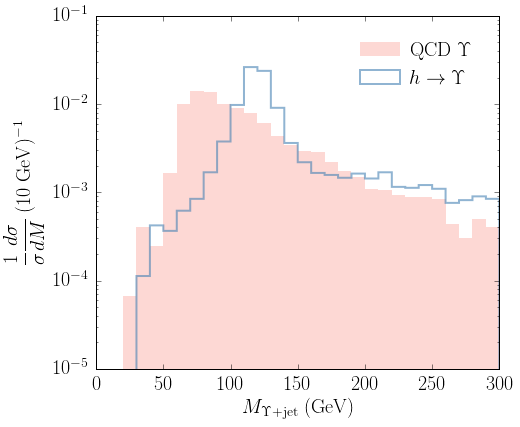

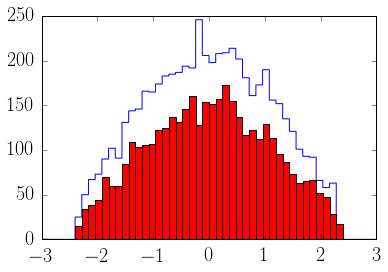

In [22]:


sig = pd.read_csv("higgs_Upsilon.evt", header=0, delimiter=',', skipinitialspace=True)
qcd = pd.read_csv("qcd_Upsilon_highweight.evt", header=0, delimiter=',', skipinitialspace=True)

sig_meta = pd.read_csv("higgs_Upsilon.meta", header=0, delimiter=',', skipinitialspace=True)
qcd_meta = pd.read_csv("qcd_Upsilon_highweight.meta", header=0, delimiter=',', skipinitialspace=True)

# lumi in inverse pb
lumi=100*1000
frac_mu=.0248
mUps = 9.4603

sig_w = np.array(48.6*lumi*frac_mu/sig_meta['nevt']).flatten()
qcd_w = np.array(qcd_meta['cxn']*lumi*frac_mu/qcd_meta['weight_sum']).flatten()

def get_dot(data):
    data['dot_S']=(data['nx_S']*data['nx_J'] + data['ny_S']*data['ny_J'])

def get_w(data,sig=False):
    if not sig:
        return data['weight']*qcd_w
    else:
        return np.repeat(sig_w, len(data.index))
    
get_dot(sig)

sig = sig.query('pT > 25 & pTj > 30. & ga_S > 0 & dot_S > 0 &' + str(mUps+.2) + '> m >' + str(mUps-.2))
qcd = qcd.query('pT > 25 & pTj > 30. & ' + str(mUps+.2) + '> m >' + str(mUps-.2))


def get_ps(data, Stau=None):
    dB=rand.exponential(data['ga_B'])
    dd = data['dot_B']*dB
    if Stau is not None:
        dd += rand.exponential(data['ga_S']*Stau)*data['dot_S']
    result=rand.normal(dd,.537)*data['m']/data['pT']
    #result=dd*data['m']/data['pT']
    return result

from scipy.special import erfc
from scipy.special import erf


def get_ps_bin(data, bins, t=None):
    if t is not None:
        bc = (bins[1:]+bins[:-1])/2.0
        factor = t*(data['dot_S']*data['ga_S']*data['m']/data['pT'])
        factor_res = 0.537*(data['m']/data['pT'])
        prod = np.exp(np.einsum('b,j->bj',bc,-1.0/factor))
        prod = np.einsum('bj,j->bj',prod, 1.0/factor)
        # get resolution
        res_factor = 0.5*np.exp(0.5*(factor_res/factor)**2)
        erfc_factor = np.add.outer(-bc, factor_res**2/factor)
        erfc_factor = erfc( np.einsum('bv,v->bv', erfc_factor, 1/(sqrt(2)*factor_res)) )

        res_factor = np.einsum('bv,v->bv', erfc_factor, res_factor)
        # multiply the resolution
        prod = prod*res_factor
        return np.sum(prod,axis=1)*sig_w
    
    else:
        bc = (bins[1:]+bins[:-1])/2.0
        fr = .537*(data['m']/data['pT'])
    
        expf = 1/sqrt(2*np.pi)*np.exp(np.multiply.outer(-bc**2, 1/(2*(fr**2)) ))
        expf = np.einsum('bj,j->bj', expf, data['weight']/fr)
        
        return np.sum(expf,axis=1)*qcd_w


    
plt.figure()

fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

plt.hist(qcd['m_Ups_j'],bins=np.linspace(0,300,31), weights=get_w(qcd)/5., normed=1, color='salmon', lw=0, alpha=.3,
        label=r'${\rm QCD\; }\Upsilon$')
plt.hist(sig['m_Ups_j'],bins=np.linspace(0,300,31), weights=get_w(sig,True), normed=1, color='steelblue', 
         histtype='step', alpha=.6, label=r'$h\rightarrow \Upsilon$',lw=2)

#plt.annotate(r'${\rm Br}(h\rightarrow \Upsilon + X)=10^{-3}$', fontsize=20,
#             xy=(.5,.9), xycoords='axes fraction' )

plt.xlabel(r'$ M_{\Upsilon + {\rm jet}} \; ({\rm GeV})$', fontsize=20)
plt.ylabel(r'$\displaystyle \frac{1}{\sigma}\frac{d\sigma}{dM} \; ({\rm 10\; GeV})^{-1}$', fontsize=20)
plt.yscale('log')


plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)

plt.yscale('log')

plt.savefig('mass.png')
plt.figure()
plt.hist(qcd['rap'],bins=np.linspace(-3,3,51), color='blue', histtype='step')
plt.hist(sig['rap'],bins=np.linspace(-3,3,51), color='red')

In [23]:

qcd=qcd.query('90 < m_Ups_j < 140 ')
sig=sig.query('90 < m_Ups_j < 140 ')


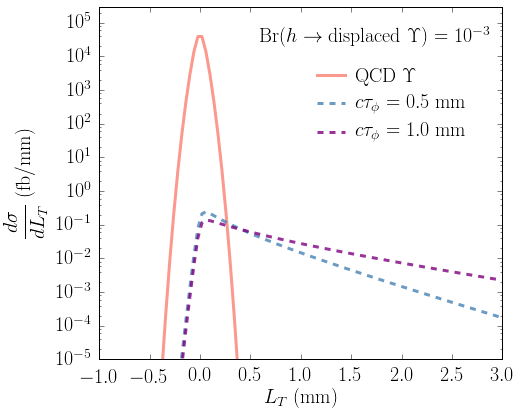

In [24]:
fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

b=np.linspace(-1,3,101)
convert_to_mm = 1/.3

b_c = (b[1:]+b[:-1])/2.
br=1e-3
qcd_v=get_ps_bin(qcd,b*convert_to_mm)*1000/lumi
sig_v_05=get_ps_bin(sig,b*convert_to_mm,0.5)*1000*br/lumi
sig_v_10=get_ps_bin(sig,b*convert_to_mm,1)*1000*br/lumi


setting = {'lw':0, 'alpha':0.4, 'bins':b}

#plt.hist(b_c, weights=qcd_v, color='olive', **setting)
plt.plot(b_c,qcd_v, color='salmon', lw=3, alpha=.8, label=r'${\rm QCD\; }\Upsilon$')
plt.plot(b_c,sig_v_05, color='steelblue',ls='dashed', lw=3, alpha=.8, label=r'$c\tau_\phi = 0.5\; {\rm mm}$')
plt.plot(b_c,sig_v_10, color='purple',ls='dashed', lw=3, alpha=.8, label=r'$c\tau_\phi = 1.0\; {\rm mm}$')
#plt.plot(b_c,qcd_v+sig_v, color='green', lw=3)


#print(qcd_v)
plt.xlabel(r'$ L_{T} \; ({\rm mm})$', fontsize=20)
plt.ylabel(r'$\displaystyle\frac{d\sigma}{dL_{T}} \; ({\rm fb/mm})$', fontsize=20)
plt.yscale('log')
plt.ylim([1e-3,1e6])

plt.legend(bbox_to_anchor=(0, 0, .93, 0.85),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.2, columnspacing=.8,
           borderaxespad=0.)

plt.annotate(r'${\rm Br}(h\rightarrow {\rm displaced}\;\Upsilon)=10^{-3}$', fontsize=20,
             xy=(.4,.9), xycoords='axes fraction' )

#plt.gca().locator_params(axis='y',nbins=5)
plt.ylim([1e-5,3e5])
plt.savefig('ups.png')


In [25]:
from scipy.optimize import bisect

def limit(t, lumi_scale=1.0):
    
    b=np.linspace(0.1,50.1,101)
    convert_to_mm = 1/.3
    qcd_c=get_ps_bin(qcd,b*convert_to_mm)*lumi_scale
    sig_c=get_ps_bin(sig,b*convert_to_mm,t)*lumi_scale
    
    def func_root(x):
        part1 = qcd_c > 100
        part2 = np.logical_not(part1)
        qcd_1 = qcd_c[part1]
        qcd_2 = qcd_c[part2]
        sig_1 = sig_c[part1]
        sig_2 = sig_c[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(sb1+0.02**2*sb1**2)
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+np.sum(logpart)+np.sum(sig_t2) - 3.84
        return my_val
    
    soln = bisect(func_root, -10.,4.)
    return soln


lifetime = 2*10.**np.linspace(-2,1.5,101)
mylimit_1 = [ limit(t) for t in lifetime ]
mylimit_1 = np.array(mylimit_1).flatten()
mylimit_30 = [ limit(t,30) for t in lifetime ]
mylimit_30 = np.array(mylimit_30).flatten()


print mylimit_1
print mylimit_30

[ 1.97287381  1.61188055  1.25755781  0.91430796  0.5851462   0.27197267
 -0.02415913 -0.30281407 -0.56399594 -0.80801258 -1.03537728 -1.2467376
 -1.4428246  -1.62441691 -1.79231554 -1.94732632 -2.09024795 -2.2218638
 -2.34293632 -2.45420318 -2.55637437 -2.65013002 -2.73611849 -2.81495477
 -2.8872192  -2.9534564  -3.01417457 -3.06984527 -3.12090357 -3.16774865
 -3.21074489 -3.25022333 -3.28648358 -3.31979593 -3.35040386 -3.37852661
 -3.40436187 -3.42808842 -3.44986869 -3.46985105 -3.48817189 -3.50495731
 -3.52032456 -3.5343831  -3.54723541 -3.55897757 -3.56969962 -3.57948588
 -3.58841509 -3.59656058 -3.60399045 -3.61076767 -3.61695033 -3.62259182
 -3.62774106 -3.63244278 -3.63673777 -3.64066315 -3.64425265 -3.64753691
 -3.65054368 -3.65329814 -3.65582306 -3.65813909 -3.66026487 -3.66221726
 -3.66401142 -3.66566083 -3.66717732 -3.66857083 -3.66984909 -3.67101712
 -3.67207658 -3.67302488 -3.67385437 -3.67455145 -3.67509586 -3.67546028
 -3.67561018 -3.67550421 -3.6750949  -3.67432977 -3.6

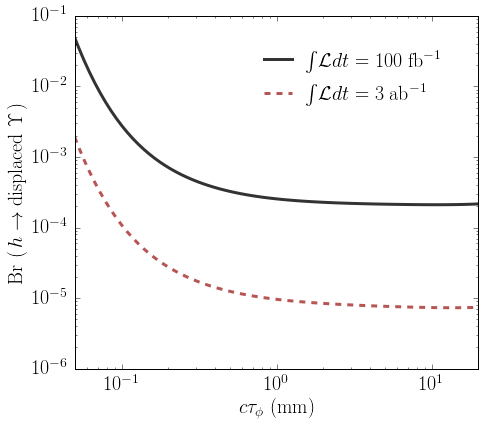

In [27]:
fig=plt.figure("limit", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)
plt.plot(lifetime, 10**mylimit_1, lw=3, alpha=.8, color='black', 
         label=r'$\int\! \mathcal{L}dt = 100 \; {\rm fb}^{-1}$')
plt.plot(lifetime, 10**mylimit_30, lw=3, alpha=.8, color='brown', ls='dashed',
        label=r'$\int\! \mathcal{L}dt = 3 \; {\rm ab}^{-1}$')

plt.xlabel(r'$ c\tau_{\phi} \; ({\rm mm})$', fontsize=20)
plt.ylabel(r'${\rm Br}\,\left(\,h\rightarrow {\rm displaced}\;\Upsilon\,\right)$', fontsize=20)

plt.legend(bbox_to_anchor=(0, 0, .93, 0.93),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.4, columnspacing=.8,
           borderaxespad=0.)

plt.yscale('log')
plt.xscale('log')
plt.xlim([.5e-1,20])
plt.ylim([1e-6,.1])
plt.savefig('limit.png')

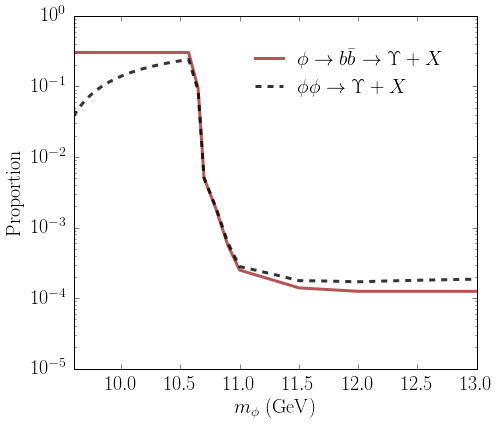

In [48]:
myeff=np.asarray([[9.46,.515],[10.57, .515],[10.65, .18],[10.7, .0101],[10.8, .0037],[10.9, .00113],[11, .0005],[11.5, .00028],[12, .00025],[13, .00025],[14, .00025]])
myeff=np.transpose(myeff)
myeff[1]=(1-np.sqrt(1-myeff[1]))

myfrac=np.asarray([[9.6, 0.0378601], [9.61, 0.0404092], [9.62, 0.0429803], [9.63,0.0455703], [9.64, 0.0481765], [9.65, 0.0507963], [9.66,0.0534274], [9.67, 0.0560673], [9.68, 0.058714], [9.69,0.0613657], [9.7, 0.0640203], [9.71, 0.0666763], [9.72,0.0693319], [9.73, 0.0719858], [9.74, 0.0746364], [9.75, 0.0772826], [9.76, 0.079923], [9.77, 0.0825566], [9.78, 0.0851823], [9.79, 0.0877991], [9.8, 0.090406], [9.81, 0.0930023], [9.82, 0.0955872], [9.83, 0.0981599], [9.84, 0.10072], [9.85, 0.103266], [9.86, 0.105798], [9.87, 0.108316], [9.88, 0.110819], [9.89, 0.113306], [9.9, 0.115777], [9.91, 0.118232], [9.92, 0.12067], [9.93, 0.123091], [9.94, 0.125495], [9.95, 0.127881], [9.96, 0.13025], [9.97, 0.132601], [9.98, 0.134933], [9.99, 0.137248], [10., 0.139544], [10.01, 0.141822], [10.02, 0.144081], [10.03, 0.146321], [10.04, 0.148543], [10.05, 0.150746], [10.06, 0.15293], [10.07, 0.155095], [10.08, 0.157242], [10.09, 0.15937], [10.1, 0.161479], [10.11, 0.163569], [10.12, 0.165641], [10.13, 0.167694], [10.14, 0.169729], [10.15, 0.171745], [10.16, 0.173742], [10.17, 0.175722], [10.18, 0.177683], [10.19, 0.179626], [10.2, 0.18155], [10.21, 0.183457], [10.22, 0.185346], [10.23, 0.187218], [10.24, 0.189071], [10.25, 0.190908], [10.26, 0.192726], [10.27, 0.194528], [10.28, 0.196313], [10.29, 0.19808], [10.3, 0.199831], [10.31, 0.201565], [10.32, 0.203283], [10.33, 0.204984], [10.34, 0.206669], [10.35, 0.208337], [10.36, 0.20999], [10.37, 0.211627], [10.38, 0.213248], [10.39, 0.214854], [10.4, 0.216444], [10.41, 0.21802], [10.42, 0.21958], [10.43, 0.221125], [10.44, 0.222655], [10.45, 0.224171], [10.46, 0.225672], [10.47, 0.227158], [10.48, 0.228631], [10.49, 0.230089], [10.5, 0.231534], [10.51, 0.232965], [10.52, 0.234382], [10.53, 0.235786], [10.54, 0.237176], [10.55, 0.238553], [10.56, 0.239918], [10.57, 0.241269], [10.58, 0.212734], [10.59, 0.187559], [10.6, 0.165349], [10.61, 0.145758], [10.62, 0.128478], [10.63, 0.113239], [10.64, 0.0997992], [10.65, 0.0879484], [10.66, 0.0496792], [10.67, 0.0280602], [10.68, 0.0158481], [10.69, 0.00895027], [10.7, 0.00505435], [10.71, 0.00459246], [10.72, 0.00417251], [10.73, 0.00379073], [10.74, 0.00344368], [10.75, 0.00312821], [10.76, 0.00284147], [10.77, 0.00258088], [10.78, 0.00234405], [10.79, 0.00212883], [10.8, 0.00193327], [10.81, 0.00172394], [10.82, 0.00153719], [10.83, 0.0013706], [10.84, 0.001222], [10.85, 0.00108946], [10.86, 0.000971252], [10.87, 0.000865826], [10.88, 0.000771808], [10.89, 0.000687968], [10.9, 0.000613207], [10.91, 0.00056719], [10.92, 0.000524604], [10.93, 0.000485194], [10.94, 0.000448726], [10.95, 0.000414982], [10.96, 0.00038376], [10.97, 0.000354873], [10.98, 0.000328148], [10.99, 0.000303423], [11., 0.000280551], [11.01, 0.000278185], [11.02, 0.000275829], [11.03, 0.000273482], [11.04, 0.000271147], [11.05, 0.000268821], [11.06, 0.000266507], [11.07, 0.000264204], [11.08, 0.000261912], [11.09, 0.000259631], [11.1, 0.000257362], [11.11, 0.000255105], [11.12, 0.000252859], [11.13, 0.000250626], [11.14, 0.000248405], [11.15, 0.000246196], [11.16, 0.000244], [11.17, 0.000241817], [11.18, 0.000239646], [11.19, 0.000237489], [11.2, 0.000235344], [11.21, 0.000233212], [11.22, 0.000231094], [11.23, 0.000228989], [11.24, 0.000226897], [11.25, 0.000224818], [11.26, 0.000222753], [11.27, 0.000220702], [11.28, 0.000218664], [11.29, 0.000216639], [11.3, 0.000214629], [11.31, 0.000212632], [11.32, 0.000210649], [11.33, 0.00020868], [11.34, 0.000206724], [11.35, 0.000204782], [11.36, 0.000202855], [11.37, 0.000200941], [11.38, 0.000199041], [11.39, 0.000197154], [11.4, 0.000195282], [11.41, 0.000193424], [11.42, 0.000191579], [11.43, 0.000189749], [11.44, 0.000187932], [11.45, 0.000186129], [11.46, 0.00018434], [11.47, 0.000182565], [11.48, 0.000180803], [11.49, 0.000179056], [11.5, 0.000177322], [11.51, 0.000177247], [11.52, 0.00017717], [11.53, 0.00017709], [11.54, 0.000177007], [11.55, 0.000176921], [11.56, 0.000176832], [11.57, 0.00017674], [11.58, 0.000176645], [11.59, 0.000176548], [11.6, 0.000176448], [11.61, 0.000176345], [11.62, 0.00017624], [11.63, 0.000176132], [11.64, 0.000176022], [11.65, 0.000175909], [11.66, 0.000175794], [11.67, 0.000175676], [11.68, 0.000175556], [11.69, 0.000175434], [11.7, 0.000175309], [11.71, 0.000175182], [11.72, 0.000175052], [11.73, 0.000174921], [11.74, 0.000174787], [11.75, 0.000174651], [11.76, 0.000174513], [11.77, 0.000174373], [11.78, 0.000174231], [11.79, 0.000174087], [11.8, 0.000173941], [11.81, 0.000173793], [11.82, 0.000173643], [11.83, 0.000173491], [11.84, 0.000173337], [11.85, 0.000173182], [11.86, 0.000173024], [11.87, 0.000172865], [11.88, 0.000172704], [11.89, 0.000172541], [11.9, 0.000172377], [11.91, 0.000172211], [11.92, 0.000172043], [11.93, 0.000171874], [11.94, 0.000171703], [11.95, 0.000171531], [11.96, 0.000171357], [11.97, 0.000171181], [11.98, 0.000171004], [11.99, 0.000170825], [12., 0.000170645], [12.01, 0.000170851], [12.02, 0.000171055], [12.03, 0.000171258], [12.04, 0.000171459], [12.05, 0.000171659], [12.06, 0.000171858], [12.07, 0.000172055], [12.08, 0.000172251], [12.09, 0.000172446], [12.1, 0.00017264], [12.11, 0.000172832], [12.12, 0.000173023], [12.13, 0.000173213], [12.14, 0.000173402], [12.15, 0.000173589], [12.16, 0.000173776], [12.17, 0.000173961], [12.18, 0.000174145], [12.19, 0.000174328], [12.2, 0.000174509], [12.21, 0.00017469], [12.22, 0.000174869], [12.23, 0.000175047], [12.24, 0.000175224], [12.25, 0.0001754], [12.26, 0.000175575], [12.27, 0.000175749], [12.28, 0.000175922], [12.29, 0.000176093], [12.3, 0.000176264], [12.31, 0.000176433], [12.32, 0.000176602], [12.33, 0.000176769], [12.34, 0.000176936], [12.35, 0.000177101], [12.36, 0.000177266], [12.37, 0.000177429], [12.38, 0.000177592], [12.39, 0.000177753], [12.4, 0.000177914], [12.41, 0.000178073], [12.42, 0.000178232], [12.43, 0.000178389], [12.44, 0.000178546], [12.45, 0.000178702], [12.46, 0.000178857], [12.47, 0.000179011], [12.48, 0.000179164], [12.49, 0.000179316], [12.5, 0.000179467], [12.51, 0.000179617], [12.52, 0.000179767], [12.53, 0.000179915], [12.54, 0.000180063], [12.55, 0.00018021], [12.56, 0.000180356], [12.57, 0.000180501], [12.58, 0.000180646], [12.59, 0.000180789], [12.6, 0.000180932], [12.61, 0.000181074], [12.62, 0.000181215], [12.63, 0.000181355], [12.64, 0.000181494], [12.65, 0.000181633], [12.66, 0.000181771], [12.67, 0.000181908], [12.68, 0.000182044], [12.69, 0.00018218], [12.7, 0.000182315], [12.71, 0.000182449], [12.72, 0.000182582], [12.73, 0.000182715], [12.74, 0.000182846], [12.75, 0.000182978], [12.76, 0.000183108], [12.77, 0.000183238], [12.78, 0.000183366], [12.79, 0.000183495], [12.8, 0.000183622], [12.81, 0.000183749], [12.82, 0.000183875], [12.83, 0.000184001], [12.84, 0.000184125], [12.85, 0.000184249], [12.86, 0.000184373], [12.87, 0.000184496], [12.88, 0.000184618], [12.89, 0.000184739], [12.9, 0.00018486], [12.91, 0.00018498], [12.92, 0.000185099], [12.93, 0.000185218], [12.94, 0.000185337], [12.95, 0.000185454], [12.96, 0.000185571], [12.97, 0.000185687], [12.98, 0.000185803], [12.99, 0.000185918], [13., 0.000186033], [13.01, 0.000186147], [13.02, 0.00018626], [13.03, 0.000186373], [13.04, 0.000186485], [13.05, 0.000186597], [13.06, 0.000186708], [13.07, 0.000186818], [13.08, 0.000186928], [13.09, 0.000187037], [13.1, 0.000187146], [13.11, 0.000187254], [13.12, 0.000187362], [13.13, 0.000187469], [13.14, 0.000187575], [13.15, 0.000187681], [13.16, 0.000187787], [13.17, 0.000187891], [13.18, 0.000187996], [13.19, 0.0001881], [13.2, 0.000188203], [13.21, 0.000188306], [13.22, 0.000188408], [13.23, 0.00018851], [13.24, 0.000188611], [13.25, 0.000188712], [13.26, 0.000188812], [13.27, 0.000188912], [13.28, 0.000189011], [13.29, 0.00018911], [13.3, 0.000189208], [13.31, 0.000189306], [13.32, 0.000189403], [13.33, 0.0001895], [13.34, 0.000189597], [13.35, 0.000189693], [13.36, 0.000189788], [13.37, 0.000189883], [13.38, 0.000189978], [13.39, 0.000190072], [13.4, 0.000190165], [13.41, 0.000190258], [13.42, 0.000190351], [13.43, 0.000190443], [13.44, 0.000190535], [13.45, 0.000190626], [13.46, 0.000190717], [13.47, 0.000190808], [13.48, 0.000190898], [13.49, 0.000190988], [13.5, 0.000191077], [13.51, 0.000191166], [13.52, 0.000191254], [13.53, 0.000191342], [13.54, 0.00019143], [13.55, 0.000191517], [13.56, 0.000191604], [13.57, 0.00019169], [13.58, 0.000191776], [13.59, 0.000191861], [13.6, 0.000191946], [13.61, 0.000192031], [13.62, 0.000192116], [13.63, 0.0001922], [13.64, 0.000192283], [13.65, 0.000192366], [13.66, 0.000192449], [13.67, 0.000192532], [13.68, 0.000192614], [13.69, 0.000192695], [13.7, 0.000192777], [13.71, 0.000192857], [13.72, 0.000192938], [13.73, 0.000193018], [13.74, 0.000193098], [13.75, 0.000193178], [13.76, 0.000193257], [13.77, 0.000193335], [13.78, 0.000193414], [13.79, 0.000193492], [13.8, 0.00019357], [13.81, 0.000193647], [13.82, 0.000193724], [13.83, 0.000193801], [13.84, 0.000193877], [13.85, 0.000193953], [13.86, 0.000194029], [13.87, 0.000194104], [13.88, 0.000194179], [13.89, 0.000194254], [13.9, 0.000194328], [13.91, 0.000194402], [13.92, 0.000194476], [13.93, 0.000194549], [13.94, 0.000194622], [13.95, 0.000194695], [13.96, 0.000194767], [13.97, 0.000194839], [13.98, 0.000194911], [13.99, 0.000194983], [14., 0.000195054], [14.01, 0.000195125], [14.02, 0.000195195], [14.03, 0.000195265], [14.04, 0.000195335], [14.05, 0.000195405], [14.06, 0.000195474], [14.07, 0.000195543], [14.08, 0.000195612], [14.09, 0.000195681], [14.1, 0.000195749], [14.11, 0.000195817], [14.12, 0.000195884], [14.13, 0.000195952], [14.14, 0.000196019], [14.15, 0.000196086], [14.16, 0.000196152], [14.17, 0.000196218], [14.18, 0.000196284], [14.19, 0.00019635], [14.2, 0.000196415], [14.21, 0.00019648], [14.22, 0.000196545], [14.23, 0.00019661], [14.24, 0.000196674], [14.25, 0.000196738], [14.26, 0.000196802], [14.27, 0.000196865], [14.28, 0.000196929], [14.29, 0.000196992], [14.3, 0.000197054], [14.31, 0.000197117], [14.32, 0.000197179], [14.33, 0.000197241], [14.34, 0.000197303], [14.35, 0.000197364], [14.36, 0.000197425], [14.37, 0.000197486], [14.38, 0.000197547], [14.39, 0.000197608], [14.4, 0.000197668], [14.41, 0.000197728], [14.42, 0.000197788], [14.43, 0.000197847], [14.44, 0.000197906], [14.45, 0.000197965], [14.46, 0.000198024], [14.47, 0.000198083], [14.48, 0.000198141], [14.49, 0.000198199], [14.5, 0.000198257], [14.51, 0.000198315], [14.52, 0.000198372], [14.53, 0.000198429], [14.54, 0.000198486], [14.55, 0.000198543], [14.56, 0.0001986], [14.57, 0.000198656], [14.58, 0.000198712], [14.59, 0.000198768], [14.6, 0.000198824], [14.61, 0.000198879], [14.62, 0.000198934], [14.63, 0.000198989], [14.64, 0.000199044], [14.65, 0.000199099], [14.66, 0.000199153], [14.67, 0.000199207], [14.68, 0.000199261], [14.69, 0.000199315], [14.7, 0.000199369], [14.71, 0.000199422], [14.72, 0.000199475], [14.73, 0.000199528], [14.74, 0.000199581], [14.75, 0.000199633], [14.76, 0.000199686], [14.77, 0.000199738], [14.78, 0.00019979], [14.79, 0.000199841], [14.8, 0.000199893], [14.81, 0.000199944], [14.82, 0.000199995], [14.83, 0.000200046], [14.84, 0.000200097], [14.85, 0.000200148], [14.86, 0.000200198], [14.87, 0.000200248], [14.88, 0.000200298], [14.89, 0.000200348], [14.9, 0.000200398], [14.91, 0.000200447], [14.92, 0.000200497], [14.93, 0.000200546], [14.94, 0.000200595], [14.95, 0.000200643], [14.96, 0.000200692], [14.97, 0.00020074], [14.98, 0.000200789], [14.99, 0.000200837], [15., 0.000200884]])
myfrac=np.transpose(myfrac)

fig=plt.figure("limit", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

plt.plot(myeff[0],myeff[1], lw=3, alpha=.8, color='brown', 
         label=r'$\phi \rightarrow b\bar{b} \rightarrow \Upsilon + X$')

plt.plot(myfrac[0],myfrac[1], lw=3, alpha=.8, color='black',ls='dashed', 
         label=r'$\phi\phi \rightarrow \Upsilon + X$')

plt.xlabel(r'$ m_\phi \; ({\rm GeV})$', fontsize=20)
plt.ylabel(r'${\rm Proportion}$', fontsize=20)


plt.legend(bbox_to_anchor=(0, 0, .93, 0.93),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.4, columnspacing=.8,
           borderaxespad=0.)


plt.yscale('log')
plt.ylim([1e-5, 1])
plt.xlim([9.6, 13.])

plt.savefig('frac.png')

In [41]:
v1=np.array([-2.0570073275e+01, -2.4927365110e+01, -1.0873707933e+02, 1.1353565020e+02])
v2=np.array([+9.0322382382e+01, -7.3336703562e+01, -1.0888364352e+02, 1.5941813785e+02])
g=np.diag([-1,-1,-1,1])
vv=v1+v2
sqrt(np.dot(vv,np.dot(g,vv)))

112.35559433937328

In [334]:
def plot(var, bins):
    f, axarr = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,5))
    setting = {'lw':0, 'alpha':0.4, 'color':'olive', 'bins':bins}
    plt.yscale('log')
    axarr[0].hist(sig[var], **setting)
    axarr[1].hist(qcd[var], **setting)
    plt.xlim([min(bins),max(bins)])
    plt.show()

nqcd = 1000
nsig = 1000
qcd_bias = 0.
qcd_list=np.array([ get_ps_new(qcd) for i in range(nqcd) ])
#sig_list=np.array([ get_ps(sig,Stau=20) for i in range(nsig) ]).flatten()




In [277]:
qcd_new

,evt,m,pT,eta,rap,phi,pTj,etaj,rapj,phij,m_JPsi_j,nx_J,ny_J,B,nx_B,ny_B,ga_B,dot_B
0,1,2.95808,12.7138,-1.53694,-1.51296,4.59833,58.2841,-0.844733,-0.840101,1.48042,58.5529,-0.046783,-0.408397,511,-0.061438,-0.414406,20.5164,0.172116


[ 0.82159551]


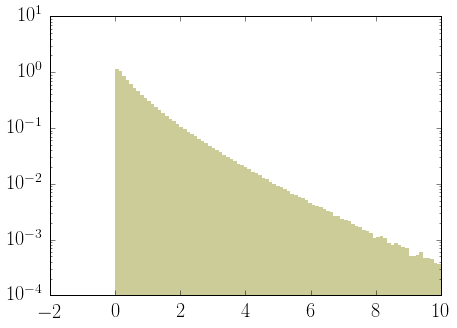

In [335]:
plt.figure(figsize=(7,5))
setting = {'lw':0, 'alpha':0.4, 'bins':np.linspace(-1,10,101)}
qcd_total = np.concatenate(qcd_list)
plt.hist(qcd_total, color='olive', normed=1, **setting)
x=np.linspace(0,19,501)
#factor=qcd_new['dot_B']*qcd_new['ga_B']*qcd_new['m']/qcd_new['pT']
#factor=np.asarray(factor).flatten()
print factor
#plt.hist(sig_list, color='blue', weights=np.repeat(sig_w, len(sig_list)), **setting)
plt.yscale('log')

In [70]:
np.concatenate(qcd_list)

array([ 24.29689848,  20.61010762,  20.22822042, ...,  21.60090931,
        21.37936283,  22.58576364])

In [55]:
np.concatenate([[1,2],[4],[3,4,5,0]])

array([1, 2, 4, 3, 4, 5, 0])

(array([  980.,    27.,    79.,   177.,   262.,   304.,   359.,   395.,
          460.,   427.,   505.,   604.,   702.,   750.,   923.,  1068.,
         1244.,  1583.,  1860.,  2162.,  2675.,  3299.,  4574.,  7057.,
         8026.,  3786.,  1154.,   570.,   498.,   400.,   345.,   296.,
          259.,   218.,   177.,   163.,   163.,   123.,   112.,    82.,
           75.,    57.,    49.,    50.,    44.,    27.,    34.,    33.,
           30.,    28.]),
 array([    0.,    40.,    80.,   120.,   160.,   200.,   240.,   280.,
          320.,   360.,   400.,   440.,   480.,   520.,   560.,   600.,
          640.,   680.,   720.,   760.,   800.,   840.,   880.,   920.,
          960.,  1000.,  1040.,  1080.,  1120.,  1160.,  1200.,  1240.,
         1280.,  1320.,  1360.,  1400.,  1440.,  1480.,  1520.,  1560.,
         1600.,  1640.,  1680.,  1720.,  1760.,  1800.,  1840.,  1880.,
         1920.,  1960.,  2000.]),
 <a list of 50 Patch objects>)

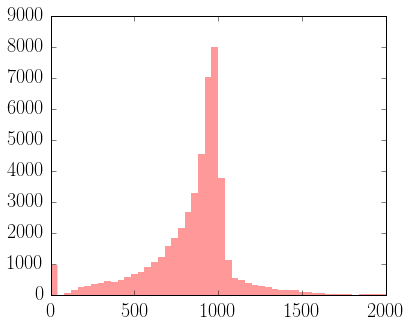

In [4]:
plt.figure(figsize=(6,5))
#plt.yscale("log", nonposy='clip')
setting = {'lw':0, 'alpha':0.4, 'bins':np.linspace(0,2000,51)}

plt.hist(list(sig.evt['m1'])+list(sig.evt['m2']), color='red', **setting)


(array([   0.,    0.,    0.,    0.,    1.,    2.,   10.,  115.,  287.,
         527.,  648.,  680.,  688.,  613.,  550.,  489.,  445.,  372.,
         327.,  281.,  256.,  207.,  204.,  164.,  174.,  131.,   89.,
          55.,   36.,   21.,   13.,   17.,    8.,    3.,    1.,    1.,
           1.,    3.,    1.,    0.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([    0.,    40.,    80.,   120.,   160.,   200.,   240.,   280.,
          320.,   360.,   400.,   440.,   480.,   520.,   560.,   600.,
          640.,   680.,   720.,   760.,   800.,   840.,   880.,   920.,
          960.,  1000.,  1040.,  1080.,  1120.,  1160.,  1200.,  1240.,
         1280.,  1320.,  1360.,  1400.,  1440.,  1480.,  1520.,  1560.,
         1600.,  1640.,  1680.,  1720.,  1760.,  1800.,  1840.,  1880.,
         1920.,  1960.,  2000.]),
 <a list of 50 Patch objects>)

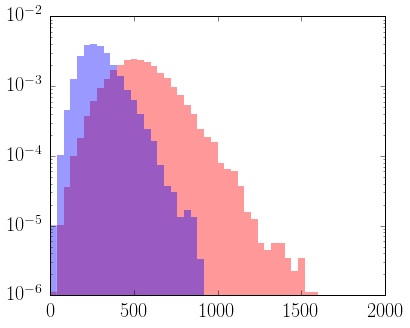

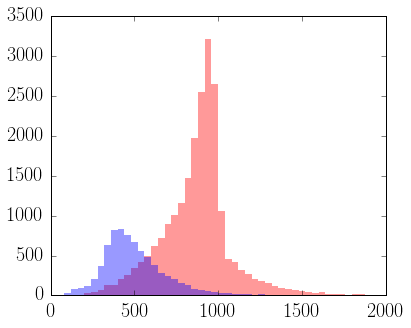

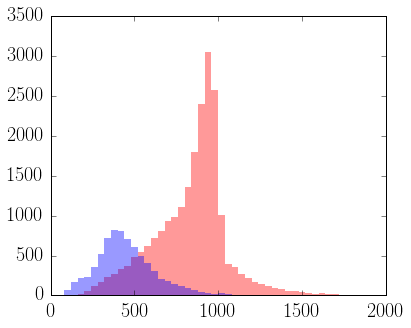

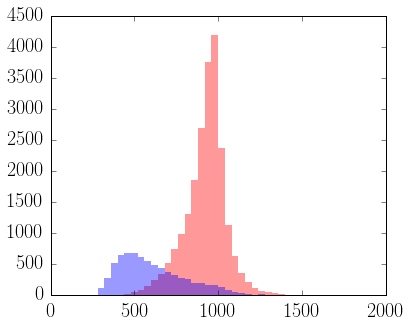

In [5]:
def epsilon(j1,j2,j3,j4):
    val = fabs(np.linalg.det([j1,j2,j3,j4]))**(1/4.0)
    mm = pt(j1)**0
    return val/mm

def avg_mass(j1,j2,j3,j4):
    m1 = fabs(m(j1+j2)-m(j3+j4))/(m(j1+j2)+m(j3+j4))
    m2 = fabs(m(j1+j3)-m(j2+j4))/(m(j1+j3)+m(j2+j4))
    m3 = fabs(m(j1+j4)-m(j3+j2))/(m(j1+j4)+m(j3+j2))
    if np.amin([m1,m2,m3]) == m1:
        return (m(j1+j2)+m(j3+j4))/2.
    elif np.amin([m1,m2,m3]) == m2:
        return (m(j1+j3)+m(j2+j4))/2.
    else:
        return (m(j1+j4)+m(j2+j3))/2

def min_mass(j1,j2,j3,j4):
    m1 = fabs(m(j1+j2)-m(j3+j4))
    m2 = fabs(m(j1+j3)-m(j2+j4))
    m3 = fabs(m(j1+j4)-m(j3+j2))
    if np.amin([m1,m2,m3]) == m1:
        return (m(j1+j2)+m(j3+j4))/2.
    elif np.amin([m1,m2,m3]) == m2:
        return (m(j1+j3)+m(j2+j4))/2.
    else:
        return (m(j1+j4)+m(j2+j3))/2

def best_mass(j1,j2,j3,j4):
    m1 = fabs(m(j1+j2)+m(j3+j4)-2000)
    m2 = fabs(m(j1+j3)+m(j2+j4)-2000)
    m3 = fabs(m(j1+j4)+m(j3+j2)-2000)
    if np.amin([m1,m2,m3]) == m1:
        return (m(j1+j2)+m(j3+j4))/2.
    elif np.amin([m1,m2,m3]) == m2:
        return (m(j1+j3)+m(j2+j4))/2.
    else:
        return (m(j1+j4)+m(j2+j3))/2


plt.figure(figsize=(6,5))
setting = {'lw':0, 'alpha':0.4, 'bins':np.linspace(0,2000,51)}


plt.yscale("log", nonposy='clip')
plt.hist(sig.get_var(epsilon), color='red', normed=1, **setting)
plt.hist(qcd.get_var(epsilon), color='blue', normed=1, **setting)

setting = {'lw':0, 'alpha':0.4, 'bins':np.linspace(0,2000,51)}

# avg_mass
plt.figure(figsize=(6,5))
#plt.yscale("log", nonposy='clip')
plt.hist(sig.get_var(avg_mass), color='red', **setting)
plt.hist(qcd.get_var(avg_mass), color='blue', **setting)

plt.figure(figsize=(6,5))
#plt.yscale("log", nonposy='clip')
plt.hist(sig.get_var(min_mass), color='red', **setting)
plt.hist(qcd.get_var(min_mass), color='blue', **setting)

plt.figure(figsize=(6,5))
#plt.yscale("log", nonposy='clip')
plt.hist(sig.get_var(best_mass), color='red', **setting)
plt.hist(qcd.get_var(best_mass), color='blue', **setting)

In [6]:
# jj1,jj2,jj3,jj4,bb = boost_to_E(sig.j[0],sig.j[1],sig.j[2],sig.j[3])
# qj1,qj2,qj3,qj4,qb = boost_to_E(qcd.j[0],qcd.j[1],qcd.j[2],qcd.j[3])
# old stuff

aa_test = np.asarray([[1,2],[1,3],[3,2]])
print np.argmin(aa_test, axis=1)

[0 0 1]


[ 441.41907584  441.41907584  854.59988453 ...,  666.04247914  373.20968592
  373.20968592]
[  908.35    827.291  1418.593 ...,   677.135   826.925   618.479]


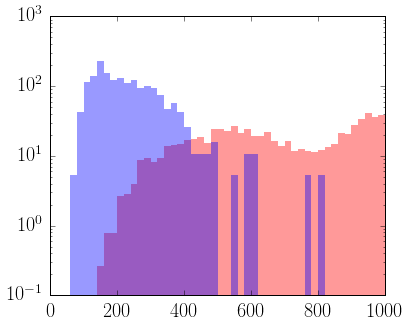

In [7]:
plt.figure(figsize=(6,5))

# find delta_R min in CMS 8TeV search
sig.j_etaphi=np.array([sig.jet_etaphi(1), sig.jet_etaphi(2), sig.jet_etaphi(3), sig.jet_etaphi(4)])
qcd.j_etaphi=np.array([qcd.jet_etaphi(1), qcd.jet_etaphi(2), qcd.jet_etaphi(3), qcd.jet_etaphi(4)])

sig.dR=np.array([np.fabs(delta_R(sig.j_etaphi[0],sig.j_etaphi[1])-1) + np.fabs(delta_R(sig.j_etaphi[2],sig.j_etaphi[3])-1), 
                 np.fabs(delta_R(sig.j_etaphi[0],sig.j_etaphi[2])-1) + np.fabs(delta_R(sig.j_etaphi[1],sig.j_etaphi[3])-1), 
                 np.fabs(delta_R(sig.j_etaphi[0],sig.j_etaphi[3])-1) + np.fabs(delta_R(sig.j_etaphi[1],sig.j_etaphi[2])-1), 
                 ]).transpose()

qcd.dR=np.array([np.fabs(delta_R(qcd.j_etaphi[0],qcd.j_etaphi[1])-1) + np.fabs(delta_R(qcd.j_etaphi[2],qcd.j_etaphi[3])-1), 
                 np.fabs(delta_R(qcd.j_etaphi[0],qcd.j_etaphi[2])-1) + np.fabs(delta_R(qcd.j_etaphi[1],qcd.j_etaphi[3])-1), 
                 np.fabs(delta_R(qcd.j_etaphi[0],qcd.j_etaphi[3])-1) + np.fabs(delta_R(qcd.j_etaphi[1],qcd.j_etaphi[2])-1), 
                 ]).transpose()


# choose a dijet pair
def dR_min(matrix):
    return np.asarray([np.argmin(matrix, axis=1), np.amin(matrix, axis=1)]).transpose()
    
# get the pair mass and pair sum pT
def pair_stat(jet_matrix, index):
    mass = []
    sumpt = []
    deta = []
    for js,i in zip(np.transpose(jet_matrix, axes=(1,0,2)), index):
        if i[0]==0:
            mass.append(np.array([ m(js[0]+js[1]), m(js[2]+js[3]) ]))
            sumpt.append(np.array([ pt(js[0])+pt(js[1]), pt(js[2])+pt(js[3]) ]))
            deta.append([ fabs(eta(js[0]+js[1]) - eta(js[2]-js[3])) ])
        elif i[0]==1:
            mass.append(np.array([ m(js[0]+js[2]), m(js[1]+js[3]) ]))
            sumpt.append(np.array([ pt(js[0])+pt(js[2]), pt(js[1])+pt(js[3]) ]))
            deta.append([ fabs(eta(js[0]+js[2]) - eta(js[1]-js[3])) ])
        else:
            mass.append(np.array([ m(js[0]+js[3]), m(js[1]+js[2]) ]))
            sumpt.append(np.array([ pt(js[0])+pt(js[3]), pt(js[1])+pt(js[2]) ]))
            deta.append([ fabs(eta(js[0]+js[3]) - eta(js[1]-js[2])) ])
    
    return np.asarray(mass), np.asarray(sumpt), np.asarray(deta)
            
        
sig.index=dR_min(sig.dR)
qcd.index=dR_min(qcd.dR)

sig.mass, sig.sumpt, sig.deta = pair_stat(sig.j, sig.index)
qcd.mass, qcd.sumpt, qcd.deta = pair_stat(qcd.j, qcd.index)

sig.dm = 2*np.fabs(sig.mass[:,0]-sig.mass[:,1])/(sig.mass[:,0]+sig.mass[:,1])
qcd.dm = 2*np.fabs(qcd.mass[:,0]-qcd.mass[:,1])/(qcd.mass[:,0]+qcd.mass[:,1])

sig.mavg = (sig.mass[:,0]+sig.mass[:,1])/2
qcd.mavg = (qcd.mass[:,0]+qcd.mass[:,1])/2

# now we have two candidates per_event
def double_array(array):
    return np.asarray([array, array]).transpose().flatten()
    
sig.dm = double_array(sig.dm)
sig.deta = double_array(sig.deta)
sig.mass = sig.mass.flatten()
sig.sumpt = sig.sumpt.flatten()
sig.mavg = double_array(sig.mavg.flatten())
sig.Delta = sig.sumpt - sig.mavg

print sig.mavg
print sig.sumpt

qcd.dm = double_array(qcd.dm)
qcd.deta = double_array(qcd.deta)
qcd.mass = qcd.mass.flatten()
qcd.sumpt = qcd.sumpt.flatten()
qcd.mavg = double_array(qcd.mavg.flatten())
qcd.Delta = qcd.sumpt - qcd.mavg

sig.mass_cut = sig.mass[ (sig.Delta > 100) & (sig.deta < 1) & (sig.dm < .15) ]
qcd.mass_cut = qcd.mass[ (qcd.Delta > 100) & (qcd.deta < 1) & (qcd.dm < .15) ]

setting = {'lw':0, 'alpha':0.4, 'bins':np.linspace(0,1000,51)}
plt.hist(sig.mass_cut, color='red', weights = sig.weight(len(sig.mass_cut)), **setting)
plt.hist(qcd.mass_cut, color='blue', weights = qcd.weight(len(qcd.mass_cut)), **setting)
plt.yscale("log", nonposy='clip')

plt.show()

(array([ 0.31181917,  0.34586057,  0.34313725,  0.30228758,  0.2954793 ,
         0.34994553,  0.32135076,  0.29411765,  0.2832244 ,  0.33632898,
         0.31862745,  0.33224401,  0.24645969,  0.31590414,  0.29684096,
         0.26960784,  0.29956427,  0.3172658 ,  0.23556645,  0.24101307,
         0.29411765,  0.24237473,  0.25326797,  0.23148148,  0.24237473,
         0.21922658,  0.2124183 ,  0.18246187,  0.19063181,  0.19744009,
         0.16884532,  0.14842048,  0.14705882,  0.11574074,  0.13071895,
         0.11982571,  0.10893246,  0.11846405,  0.08714597,  0.07489107,
         0.0708061 ,  0.0585512 ,  0.0708061 ,  0.05446623,  0.05310458,
         0.03676471,  0.02995643,  0.02587146,  0.02723312,  0.02995643]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3

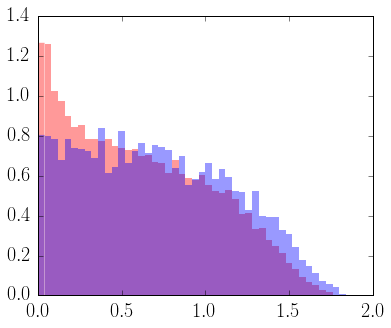

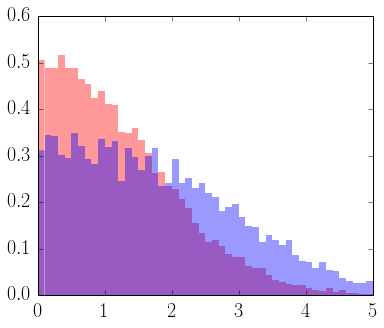

In [8]:
plt.figure(figsize=(6,5))


setting = {'lw':0, 'alpha':0.4, 'bins':np.linspace(0,2,51), 'normed':1}
plt.hist(sig.dm, color='red', weights = sig.weight(len(sig.dm)), **setting)
plt.hist(qcd.dm, color='blue', weights = qcd.weight(len(qcd.dm)), **setting)
#plt.yscale("log", nonposy='clip')


plt.figure(figsize=(6,5))


setting = {'lw':0, 'alpha':0.4, 'bins':np.linspace(0,5,51), 'normed':1}
plt.hist(sig.deta, color='red', weights = sig.weight(len(sig.dm)), **setting)
plt.hist(qcd.deta, color='blue', weights = qcd.weight(len(qcd.dm)), **setting)
